### CONFIGURATION

In [53]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 200)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
import chromosomeDefinition as cd
%matplotlib inline

In [54]:
#PYFAIDX
from pyfaidx import Fasta
genes = Fasta('/Users/peterpriestley/hmf/data/refgenomes/Homo_sapiens.GRCh37.GATK.illumina/Homo_sapiens.GRCh37.GATK.illumina.fasta')

In [55]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [56]:
#VCF
VCF_PATH = "/Users/peterpriestley/hmf/analyses/CPCT02020433/"
# BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
#BED_FILE_NAME = "cosmicCancerCensus.bed" 
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_NON_BED_MUTATIONS = True

# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [57]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [58]:
# SPECIFY SAMPLES
VCF_SAMPLES=[]
for x in os.listdir(VCF_PATH):
    #if x[-10:] == "sliced.vcf":
    #    VCF_SAMPLES.append(x[40:52] + "R_" + x[40:52] + "T_merged_somatics_snpEff_dbSNP_Cosmicv76_melted.vcf")
    if x[-10:] == "melted.vcf":
        VCF_SAMPLES.append(x)
#VCF_SAMPLES=['CPCT02030250melted.vcf']
#VCF_SAMPLES = ['CPCT02070011T_melted.vcf']
print VCF_SAMPLES

['CPCT02020433R_CPCT02020433T_merged_somatics_annotated_melted.vcf']


<h3> LOAD VCF

In [59]:
for VCF_SAMPLE in VCF_SAMPLES:
    print VCF_SAMPLE[14:27]

CPCT02020433T


In [60]:
#Load all VCF_SAMPLES to DF
df = pd.DataFrame({})
for VCF_SAMPLE in VCF_SAMPLES:
    VCF_FILE_NAME = VCF_SAMPLE
    SAMPLE_NAMES = {VCF_SAMPLE[14:27]:'melted'}
    #SAMPLE_NAMES = {VCF_SAMPLE[11:27:'melted'}
    #SAMPLE_NAMES = {"/sample/output/160604_HMFreg0056_FR10302029_FR10302030_CPCT02010299/somaticVariants/CPCT02010299R_CPCT02010299T/CPCT02010299R_CPCT02010299T_merged_somatics_snpEff_dbSNP_Cosmicv76":'melted'}
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True,True,bed,LOAD_NON_BED_MUTATIONS)])
        #df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,{'CPCT02070011T':'melted'},"CPCT02070011",True,True,bed,LOAD_NON_BED_MUTATIONS)])
    else:
        df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE[14:len(VCF_SAMPLE)-37],True)])

reading vcf file: CPCT02020433R_CPCT02020433T_merged_somatics_annotated_melted.vcf
reading VCF File line: 1
Number variants loaded: 49727


In [61]:
df = loadHealthChecksAndMerge(df)

### PON FILTERING

In [62]:
dfPON = aVCF.loadPON("/Users/peterpriestley/hmf/analyses/PON/","PON.tsv")

In [63]:
#del df['PONCount']
#del df['inPON']

In [64]:
df = pd.merge(df,dfPON,how='left', on=['chrom','pos'])
df['PONCount'].fillna(0, inplace=True)
df['inPON'] = df.PONCount>0

In [65]:
df.head(1)

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedSVLenMin,meltedSVLenMax,meltedSVStartMin,meltedSVStartMax,patientName,TUMOR_PERCENTAGE,TUMOR_TYPE,PIPELINE_VERSION,PONCount,inPON
0,1,10234,1:10234,1.000041,rs145599635,C,varscan,1,SNP,,PASS,,True,False,,,,,False,T,0.127907,94,-1.0,0/1,,,,,,CPCT02020433R_CPCT02020433T_merged_somatics_an...,Unknown,Unknown,Unknown,0,False


In [66]:
pd.pivot_table(df[(df['consensus']==True)], values='pos', index=['inPON','numCallers'], columns=['consensus','variantType'], aggfunc='count',margins=False).fillna("")

consensus         True        
variantType      INDEL     SNP
inPON numCallers              
False 2            220  1549.0
      3            142   475.0
      4                 4969.0
True  2            372   232.0
      3              5   220.0
      4                   57.0

<h3> High Level Stats

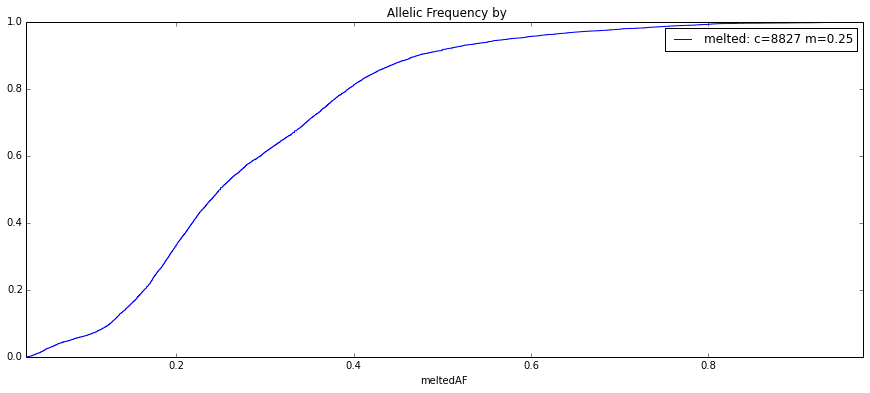

In [83]:
dftemp = df[(df['consensus']==True)]#&(df['tumorSGT']<>"1/1")]
#Alllele Freq By Caller
for columnName in list(dftemp):
    if columnName.endswith('AF'):
        ser = dftemp[columnName]
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-2]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6])

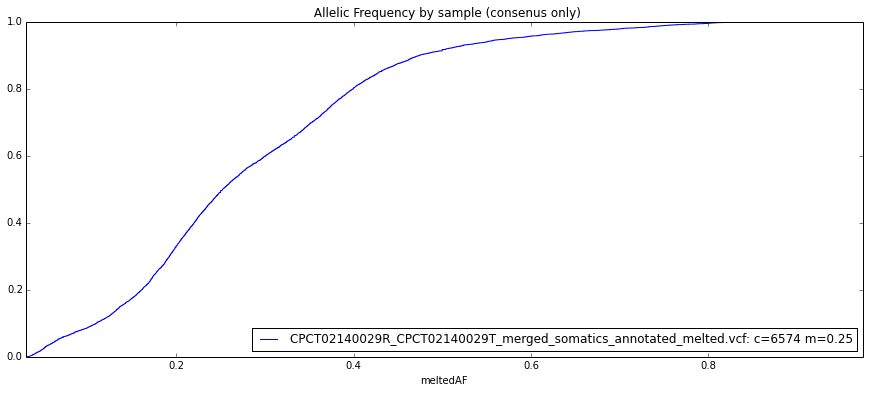

In [84]:
dftemp = df[(df['variantType']=='SNP')&(df['consensus']==True)]#&(df['tumorSGT']<>"1/1")]
#Alllele Freq By Patient Name
patientNames = dftemp.patientName.unique()
for patientName in patientNames:
    ser = dftemp[(dftemp.patientName==patientName)]['meltedAF']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=patientName+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by sample (consenus only)",figsize=[15,6])

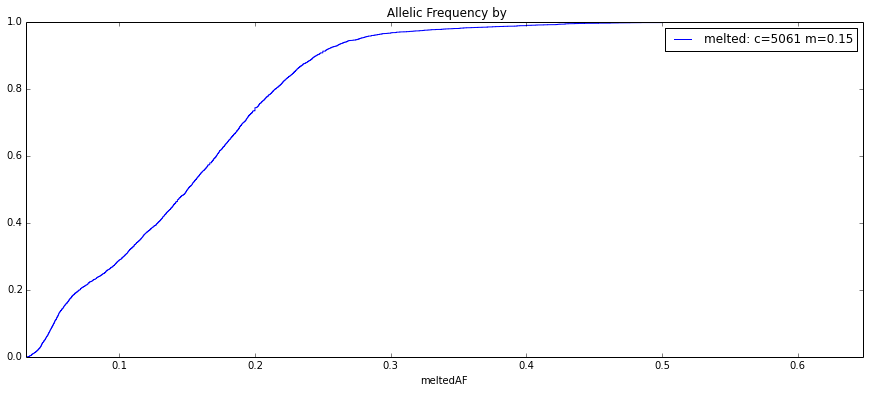

In [43]:
dftemp = df[(df['consensus']==True)&(df['variantType']=='SNP')]#&(df['tumorSGT']<>"1/1")]
#Alllele Freq By Caller
for columnName in list(dftemp):
    if columnName.endswith('AF'):
        ser = dftemp[columnName]
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-2]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6])

### HIGH and MODERATE impact NON-missense

In [24]:
#pd.pivot_table(df, values='pos', index=['chromPos','patientName','TUMOR_TYPE','annGene','annWorstImpact','annWorstEffect','consensus','meltedAF'], columns=['inCOSMIC'], aggfunc='count',margins=True).fillna("")

### Missense

In [86]:
df[(df.annAllEffects.str.contains("missense"))]

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedSVLenMin,meltedSVLenMax,meltedSVStartMin,meltedSVStartMax,patientName,TUMOR_PERCENTAGE,TUMOR_TYPE,PIPELINE_VERSION


In [11]:
pd.pivot_table(df[(df.annAllEffects.str.contains("missense"))], values='pos', index=['variantType','numCallers'], columns=['consensus','inDBSNP','bedRegion'], aggfunc='count',margins=True).fillna("")

consensus              False                       True            All
inDBSNP                False         True         False               
bedRegion                    Default      Default       Default       
variantType numCallers                                                
SNP         1             68      34   37       1                140.0
            2              6            6                     2   14.0
            3                                         4       2    6.0
            4                                         5      20   25.0
All                       74      34   43       1     9      24  185.0

In [74]:
pd.pivot_table(df, values='pos', index=['variantType','numCallers'], columns=['consensus','inDBSNP','bedRegion'], aggfunc='count',margins=True).fillna("")

consensus               False                         True                            All
inDBSNP                 False           True         False         True                  
bedRegion                     Default        Default       Default      Default          
variantType numCallers                                                                   
INDEL       1            3507    2109                                              5616.0
            2                                          219     733                  952.0
            3                                           65     353                  418.0
SNP         1           26703   52779   9512   61858                             150852.0
            2            1375          12427  146243          2999               163044.0
            3                                          906    7677  501    4975   14059.0
            4                                          386    3706   46     141    4279.0
All                     31585   54888  21939  208101  1576   15468  547    5116  339220.0

In [ ]:
len(df[(df.annAllEffects.str.contains("missense"))&(df.bedRegion <> '')])

### Consensus

In [ ]:
pd.pivot_table(df, values='pos', index=['variantType','numCallers'], columns=['consensus','inDBSNP','bedRegion'], aggfunc='count',margins=True).fillna("")

### Mutational Patterns

In [ ]:
pd.pivot_table(df[(df.ref.str.len()==1)&(df.variantType == 'SNP')], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

In [ ]:
pd.pivot_table(df[df.annAllEffects.str.contains("missense")], values='pos', index=['chromPos','patientName','annGene','meltedAF','numCallers','inCOSMIC'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### SINGLE PATIENT ANALYSIS

In [ ]:
df[(df.patientName=='CPCT02140013')]#[['patientName','TUMOR_TYPE','pos','chrom','id','variantType','ref','meltedallele','meltedDP','meltedAF','vennSegment','annGene']].head(20)

### SCRATCH

In [ ]:
pd.pivot_table(df, values='pos', index=['numCallers','vennSegment'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

In [ ]:
df[df.numCallers ==1]

In [ ]:
def refgenomeContext(chromPos):
    chrom = chromPos.split(':')[0]
    pos = int(chromPos.split(':')[1])
    try:
        return str(genes[chrom][pos-2:pos+1][:3])
    except TypeError:
        return -1

In [ ]:
refgenomeContext('7:467652')

In [ ]:
df['refTriplet'] =df['chromPos'].apply(lambda x: refgenomeContext(x))

In [ ]:
df.head(1)

In [ ]:
pd.pivot_table(df[df.variantType=='SNP'], values='pos', index=['refTriplet','meltedallele'], columns=['inDBSNP'], aggfunc='count',margins=True).fillna("").sort_values('All',ascending=False)

### VENN

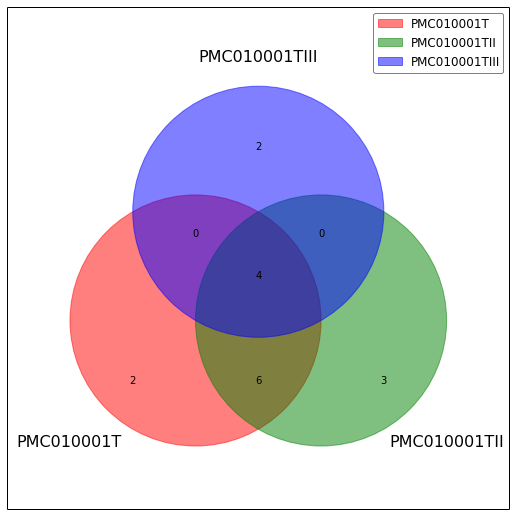

In [100]:
dftemp = df[(df.consensus== True)&(df.variantType == "SNP")&(df.annAllEffects.str.contains('missense'))&(df.inPON==False)]
vn.venn([dftemp[dftemp.patientName == 'PMC010001T']['chromPos'],dftemp[dftemp.patientName == 'PMC010001TII']['chromPos'], \
        dftemp[dftemp.patientName == 'PMC010001TIII']['chromPos']],['PMC010001T','PMC010001TII','PMC010001TIII'],figsize=(9,9))

### Common mutations

In [95]:
len(df)

6744267

In [90]:
# Calls with more than 1 instance
dfTemp = df[['consensus','inPON','numCallers','vennSegment','variantType','chrom','pos','bedRegion','annGene','annWorstEffect','chromPos','id']].groupby(['inPON','consensus','numCallers','vennSegment','variantType','chrom','pos','bedRegion','annGene','annWorstEffect','id']).agg('count').sort_values('chromPos',ascending=False)
dfTemp = dfTemp[dfTemp.chromPos>1]
len(dfTemp)

709143

In [ ]:
#dfTemp = pd.pivot_table(df[(df.bedRegion=='Default')], values='chromPos', index=['chrom','pos','annGene','annWorstEffect','id'], columns=['bedRegion'], aggfunc='count',margins=True).fillna("")
#dfTemp = dfTemp[dfTemp.All>1].sort_values('All',ascending=False)
#len(dfTemp)

In [91]:
dfTemp = dfTemp.reset_index()

In [73]:
dfTemp[(dfTemp.consensus==True)][['inPON','variantType','numCallers','chromPos']].groupby(['inPON','variantType','numCallers']).agg('count')  #.reset_index().sort_values('numCallers',ascending=False)

NameError: name 'dfTemp' is not defined

In [ ]:
dfTemp
dfTemp.groupby(['TUMOR_TYPE']).agg('count')['patientName']

In [ ]:
#temp.reset_index
#groupby(['bedRegion']).agg('count')

In [ ]:
temp.sort_values('All',ascending=False)

In [ ]:
pd.pivot_table(df, values='pos', index=['annWorstEffect'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### SOMATIC AF

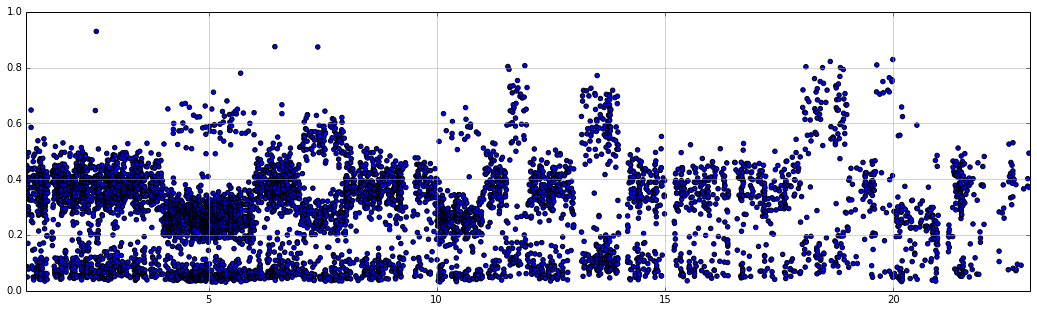

In [69]:
############### SOMATIC AF ##############
c = 1
fractionMin = 0
fractionMax = 22
dfSom = df[(df['variantType']=="SNP")&(df['inDBSNP']==False)&(df['inPON']==False)&(df['consensus']==True)&(df.chromFrac>c+fractionMin)&(df.chromFrac<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromFrac, dfSom.meltedAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()

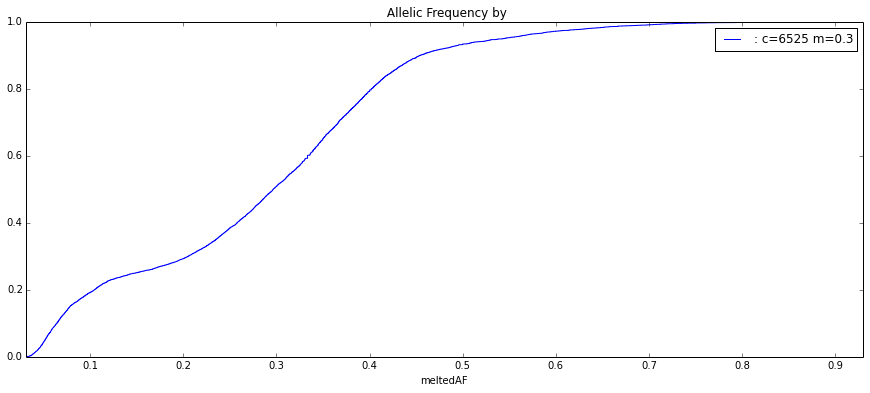

In [70]:
ser = dfSom.meltedAF
ser = ser.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6])

### COPY NUM vs SOMATIC AF

In [101]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [105]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss']
CNV_PATH="/Users/peterpriestley/hmf/analyses/CPCT02140029/"
CNV_FILENAMES=[]
for x in os.listdir(CNV_PATH):
    if x[-9:] == ".bam_CNVs":
        CNV_FILENAMES.append(x)
CNV_FILENAMES

['CPCT02140029T_dedup.realigned.bam_CNVs']

In [132]:
def calculateCopyNumForVariant(chromosome,position):
    return dfCNV[(dfCNV.chrom==chromosome)&(dfCNV.posStart<position)&(dfCNV.posEnd>=position)]['copyNum'].mean()

In [108]:
for filename in CNV_FILENAMES:
    patientName=filename[:12]
    dfCNV = loadCNVforPatient(CNV_PATH+filename,patientName)

In [118]:
df.head(1)

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedSVLenMin,meltedSVLenMax,meltedSVStartMin,meltedSVStartMax,patientName,TUMOR_PERCENTAGE,TUMOR_TYPE,PIPELINE_VERSION,PONCount,inPON
0,1,15717,1:15717,1.000063,.,A,mutect,1,SNP,,PASS,,False,False,WASH7P,MODIFIER,intron_variant,intron_variant|intron_variant|intron_variant|i...,False,G,0.034483,233,-1.0,0/1,,,,,,CPCT02140029R_CPCT02140029T_merged_somatics_an...,Unknown,Unknown,Unknown,0,False


In [131]:
#df['intchrom']=
df['copyNum']=np.vectorize(calculateCopyNumForVariant)( df['chrom'].apply(lambda x: cd.intChrom(x)),(df.pos))

### SCRATCH

In [104]:
genes['1'][10298755:10298770]

>1:10298756-10298770
CCATCCAAAAACAAC

In [150]:
len(df[(df.inPON==False)&(df.inDBSNP==True)&(df.consensus==True)&(df.annAllEffects.str.contains("missense"))])

25

In [125]:
len(df)

339220